# Evaluation notebook
This notebook is built to test my implementations of various numerical methods in C.

In [41]:
import ctypes
import numpy as np
import matplotlib.pyplot as plt 

from scipy.stats import linregress

lib = ctypes.CDLL("../lib.so")

In [3]:
def gauss(x):
    return 0.5 * np.exp(-0.5 * (x - 20)**2 / 5**2)

def dgauss(x):
    return -(x - 20) / 5**2 * gauss(x)

def compute_LAE(xs, ys, ref_f):
    return np.sum(np.abs(ys - ref_f(xs)))

# Interpolators

In [80]:
itp_argtypes = [
    np.ctypeslib.ndpointer(dtype=ctypes.c_longdouble, ndim=1, flags=('C','W')),
    np.ctypeslib.ndpointer(dtype=ctypes.c_longdouble, ndim=1, flags=('C','W')),
    np.ctypeslib.ndpointer(dtype=ctypes.c_longdouble, ndim=1, flags=('C','W')),
    ctypes.c_int
]

lib.linear_itp.argtypes     = itp_argtypes
lib.cubic_itp.argtypes      = itp_argtypes
lib.spline_itp.argtypes     = itp_argtypes

def itp(interp, xs, ys):
    n = len(xs) - 1
    out = np.empty(n, dtype=ctypes.c_longdouble)
    interp(out, xs.astype(ctypes.c_longdouble), ys.astype(ctypes.c_longdouble), n)
    return out

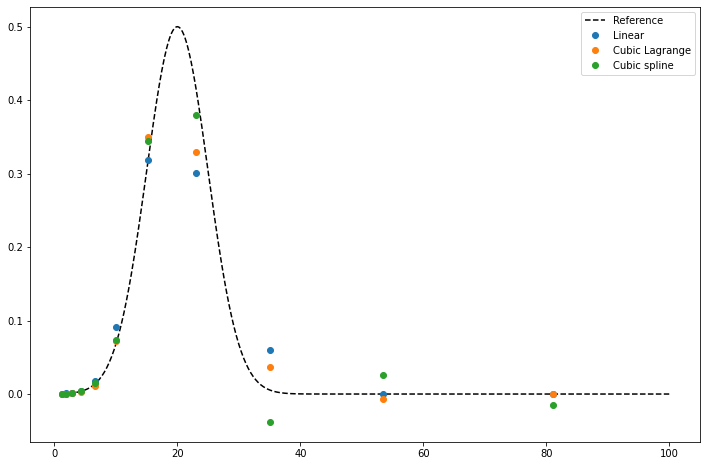

In [81]:
# Make samples
xs = np.geomspace(1, 100, 12)
ys = gauss(xs)

# Plot
plt.figure(figsize=(12,8))
xref = np.linspace(1, 100, 500)
plt.plot(xref, gauss(xref), 'k--')
edges = np.sqrt(xs[:-1] * xs[1:])

for i in [lib.linear_itp, lib.cubic_itp, lib.spline_itp]:
    lin = itp(i, xs, ys)
    plt.plot(edges, lin, 'o')

plt.legend(['Reference', 'Linear', 'Cubic Lagrange', 'Cubic spline'])
plt.show()

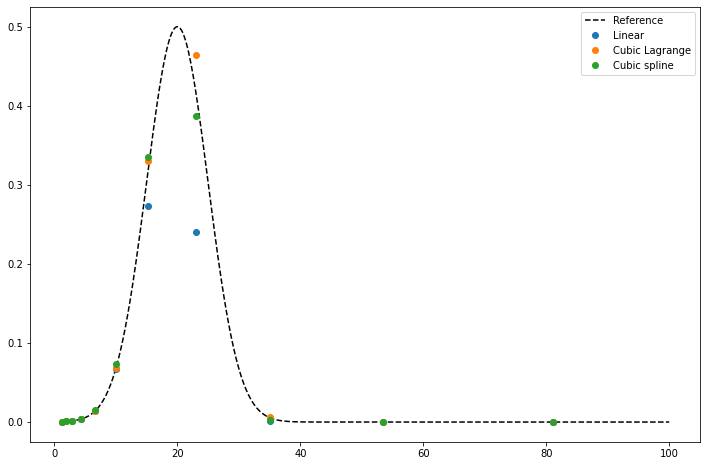

In [82]:
# Make samples
xs = np.geomspace(1, 100, 12)
ys = gauss(xs)

# Plot
plt.figure(figsize=(12,8))
xref = np.linspace(1, 100, 500)
plt.plot(xref, gauss(xref), 'k--')
edges = np.sqrt(xs[:-1] * xs[1:])

for i in [lib.linear_itp, lib.cubic_itp, lib.spline_itp]:
    lin = np.exp(itp(i, xs, np.log(ys)))
    plt.plot(edges, lin, 'o')

plt.legend(['Reference', 'Linear', 'Cubic Lagrange', 'Cubic spline'])
plt.show()

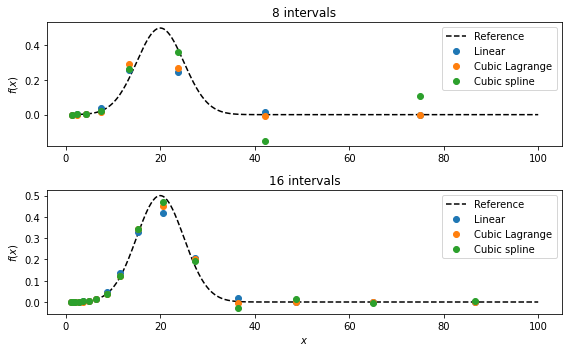

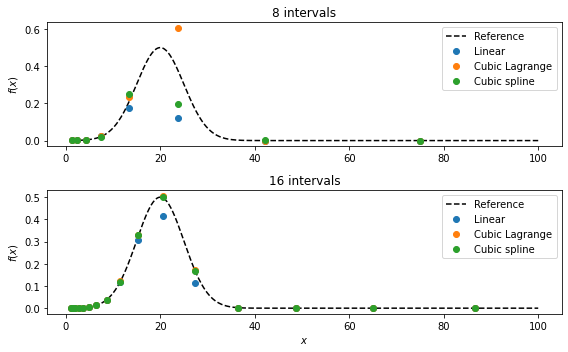

In [135]:
nbins = [8, 16]

fig, ax = plt.subplots(len(nbins),1, figsize=(8,5), tight_layout=True)
for a in ax:
    xref = np.linspace(1, 100, 500)
    a.plot(xref, gauss(xref), 'k--')

for a, n in zip(ax, nbins):
    a.set_title(f'{n} intervals')

for i, n in enumerate(nbins):
    xs = np.geomspace(1, 100, n+1)
    ys = gauss(xs)
    edges = np.sqrt(xs[:-1] * xs[1:])

    for d in [lib.linear_itp, lib.cubic_itp, lib.spline_itp]:
        lin = itp(d, xs, ys)
        ax[i].plot(edges, lin, 'o')

for a in ax:
    a.set_ylabel("$f(x)$")
    a.legend(['Reference', 'Linear', 'Cubic Lagrange', 'Cubic spline'])
ax[-1].set_xlabel('$x$')
# ax[-1].legend(['Reference', 'Linear', 'Cubic Lagrange', 'Cubic spline'])
plt.savefig('plots/itp_methods.pdf', bbox_inches='tight')
plt.show()


fig, ax = plt.subplots(len(nbins),1, figsize=(8,5), tight_layout=True)
for a in ax:
    xref = np.linspace(1, 100, 500)
    a.plot(xref, gauss(xref), 'k--')

for a, n in zip(ax, nbins):
    a.set_title(f'{n} intervals')

for i, n in enumerate(nbins):
    xs = np.geomspace(1, 100, n+1)
    ys = gauss(xs)
    edges = np.sqrt(xs[:-1] * xs[1:])

    for d in [lib.linear_itp, lib.cubic_itp, lib.spline_itp]:
        lin = np.exp(itp(d, np.log(xs), np.log(ys)))
        ax[i].plot(edges, lin, 'o')

for a in ax:
    a.set_ylabel("$f(x)$")
    a.legend(['Reference', 'Linear', 'Cubic Lagrange', 'Cubic spline'])
ax[-1].set_xlabel('$x$')
# ax[-1].legend(['Reference', 'Linear', 'Cubic Lagrange', 'Cubic spline'])
plt.savefig('plots/itp_methods_logexp.pdf', bbox_inches='tight')
plt.show()

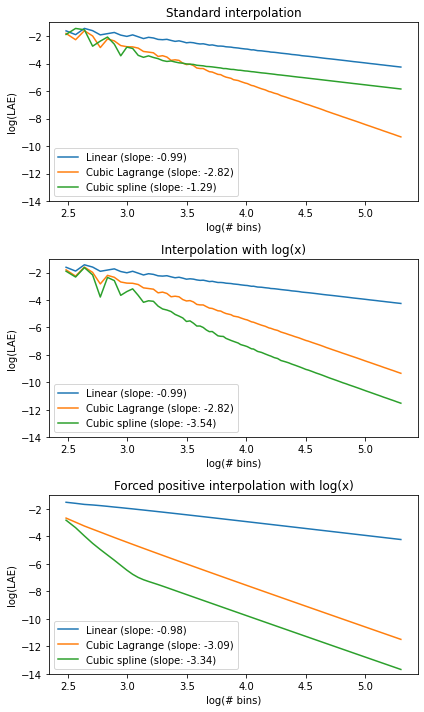

In [147]:
# Error versus number of bins
def get_errs(interp, nbins, pos=False, logx=False):
    errs = []
    for n in nbins:
        xs = np.geomspace(1, 100, n)
        ys = gauss(xs)

        x_itp = np.sqrt(xs[:-1] * xs[1:])
        if pos and logx: lin = np.exp(itp(interp, np.log(xs), np.log(ys)))
        elif pos:        lin = np.exp(itp(interp, xs, np.log(ys)))
        elif logx:       lin = itp(interp, np.log(xs), ys)
        else:            lin = itp(interp, xs, ys)
        errs.append(compute_LAE(x_itp, lin, gauss))
    return errs

nbins = np.unique(np.geomspace(12, 200, 100).astype(int))
fmt = '-'

fig, ax = plt.subplots(3, 1, figsize=(6,10), tight_layout=True)
for i, l in zip([lib.linear_itp, lib.cubic_itp, lib.spline_itp],
                ['Linear', 'Cubic Lagrange', 'Cubic spline']):
    e = get_errs(i, nbins, pos=False, logx=False)
    slope = linregress(np.log(nbins), np.log(e).astype('float64')).slope
    ax[0].plot(np.log(nbins), np.log(e), fmt, label=f"{l} (slope: {slope:.2f})")

    e = get_errs(i, nbins, pos=False, logx=True)
    slope = linregress(np.log(nbins), np.log(e).astype('float64')).slope
    ax[1].plot(np.log(nbins), np.log(e), fmt, label=f"{l} (slope: {slope:.2f})")

    e = get_errs(i, nbins, pos=True, logx=True)
    slope = linregress(np.log(nbins), np.log(e).astype('float64')).slope
    ax[2].plot(np.log(nbins), np.log(e), fmt, label=f"{l} (slope: {slope:.2f})")
ax[0].set_title('Standard interpolation')
ax[1].set_title('Interpolation with log(x)')
ax[2].set_title('Forced positive interpolation with log(x)')
for a in ax:
    a.set_xlabel('log(# bins)')
    a.set_ylabel('log(LAE)')
    a.set_ylim((-14,-1))
    a.legend()
plt.savefig('plots/itp_error.pdf', bbox_inches='tight')
plt.show()

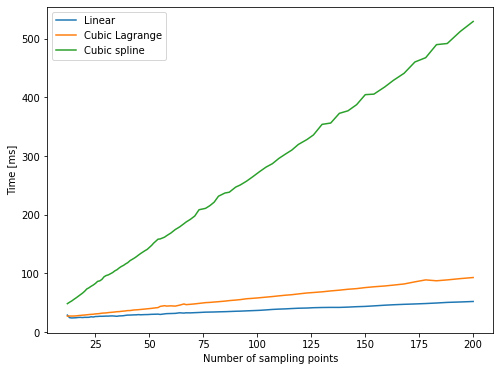

In [148]:
# Time versus number of bins
from datetime import datetime, timedelta

def get_times(interp, nbins):
    times = []
    for n in nbins:
        xs = np.geomspace(1, 100, n)
        ys = gauss(xs)

        trials = []
        for t in range(1000):
            start = datetime.now()
            lin = itp(interp, xs, ys)
            stop = datetime.now()
            trials.append((stop - start) / timedelta(microseconds=1))
        times.append(np.average(trials))
    return times

nbins = np.unique(np.geomspace(12, 200, 100).astype(int))
plt.figure(figsize=(8,6))
for i in [lib.linear_itp, lib.cubic_itp, lib.spline_itp]:
    times = get_times(i, nbins)
    plt.plot(nbins, times, '-')
    # plt.plot(np.log(nbins), np.log(times), '.')
plt.legend(['Linear', 'Cubic Lagrange', 'Cubic spline'])
plt.xlabel('Number of sampling points')
plt.ylabel('Time [ms]')
plt.savefig('plots/itp_time.pdf', bbox_inches='tight')
plt.show()

# Differentiators

In [42]:
dif_argtypes = [
    np.ctypeslib.ndpointer(dtype=ctypes.c_longdouble, ndim=1, flags=('C','W')),
    np.ctypeslib.ndpointer(dtype=ctypes.c_longdouble, ndim=1, flags=('C','W')),
    np.ctypeslib.ndpointer(dtype=ctypes.c_longdouble, ndim=1, flags=('C','W')),
    ctypes.c_int
]

lib.linear_diff.argtypes     = dif_argtypes
lib.cubic_diff.argtypes      = dif_argtypes
lib.spline_diff.argtypes     = dif_argtypes

def dif(deriv, xs, ys):
    n = len(xs) - 1
    out = np.empty(n, dtype=ctypes.c_longdouble)
    deriv(out, xs.astype(ctypes.c_longdouble), ys.astype(ctypes.c_longdouble), n)
    return out

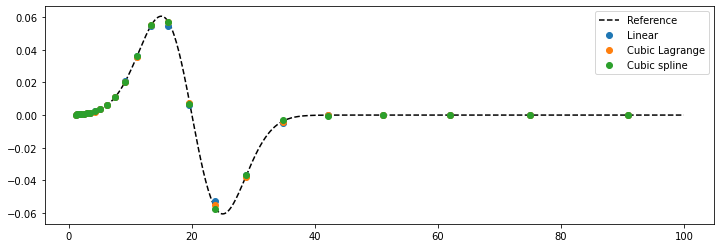

In [104]:
# Make samples
xs = np.geomspace(1, 100, 25)
ys = gauss(xs)

# Plot
plt.figure(figsize=(12,4))
xref = np.linspace(1, 100, 500)
plt.plot(xref, dgauss(xref), 'k--')
edges = np.sqrt(xs[:-1] * xs[1:])

for d in [lib.linear_diff, lib.cubic_diff, lib.spline_diff]:
    lin = dif(d, xs, ys)
    plt.plot(edges, lin, 'o')

plt.legend(['Reference', 'Linear', 'Cubic Lagrange', 'Cubic spline'])
plt.show()

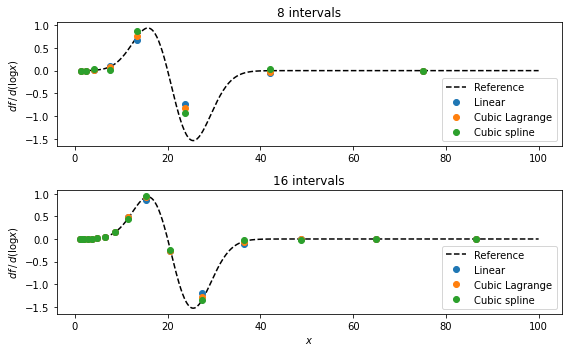

In [137]:
nbins = [8, 16]

fig, ax = plt.subplots(len(nbins),1, figsize=(8,5), tight_layout=True)
for a in ax:
    xref = np.linspace(1, 100, 500)
    a.plot(xref, xref * dgauss(xref), 'k--')

for a, n in zip(ax, nbins):
    a.set_title(f'{n} intervals')

for i, n in enumerate(nbins):
    xs = np.geomspace(1, 100, n+1)
    ys = gauss(xs)
    edges = np.sqrt(xs[:-1] * xs[1:])

    for d in [lib.linear_diff, lib.cubic_diff, lib.spline_diff]:
        lin = dif(d, np.log(xs), ys)
        ax[i].plot(edges, lin, 'o')

for a in ax:
    a.legend(['Reference', 'Linear', 'Cubic Lagrange', 'Cubic spline'])
    a.set_ylabel("$df\,/\,d(\log x)$")
ax[-1].set_xlabel('$x$')
plt.savefig('plots/deriv_methods.pdf', bbox_inches='tight')
plt.show()

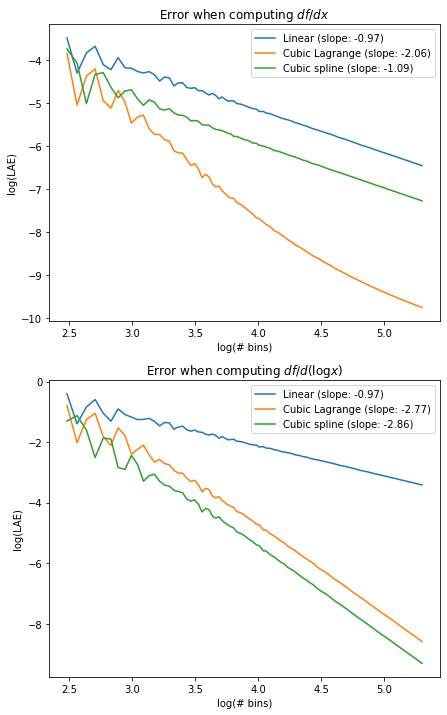

In [102]:
# Error versus number of bins
def get_errs(deriv, nbins, logx=False):
    errs = []
    for n in nbins:
        xs = np.geomspace(1, 100, n+1)
        ys = gauss(xs)

        x_itp = np.sqrt(xs[:-1] * xs[1:])

        if logx:
            lin = dif(deriv, np.log(xs), ys)
            dgauss_dlogx = lambda x: x * dgauss(x)
            errs.append(compute_LAE(x_itp, lin, dgauss_dlogx))
        else:
            lin = dif(deriv, xs, ys)
            errs.append(compute_LAE(x_itp, lin, dgauss))

    return errs

nbins = np.unique(np.geomspace(12, 200, 100).astype(int))

fig, ax = plt.subplots(2, 1, figsize=(7,12))
for d, l in zip([lib.linear_diff, lib.cubic_diff, lib.spline_diff],
                ['Linear', 'Cubic Lagrange', 'Cubic spline']):
    e = get_errs(d, nbins)
    slope = linregress(np.log(nbins), np.log(e).astype('float64')).slope
    ax[0].plot(np.log(nbins), np.log(e), '-', label=f"{l} (slope: {slope:.2f})")
    
    e = get_errs(d, nbins, logx=True)
    slope = linregress(np.log(nbins), np.log(e).astype('float64')).slope
    ax[1].plot(np.log(nbins), np.log(e), '-', label=f"{l} (slope: {slope:.2f})")

ax[0].set_title('Error when computing $df/dx$')
ax[1].set_title('Error when computing $df/d(\log x)$')
for a in ax:
    a.set_xlabel('log(# bins)')
    a.set_ylabel('log(LAE)')
    a.legend()
plt.savefig('plots/deriv_error.pdf', bbox_inches='tight')
plt.show()

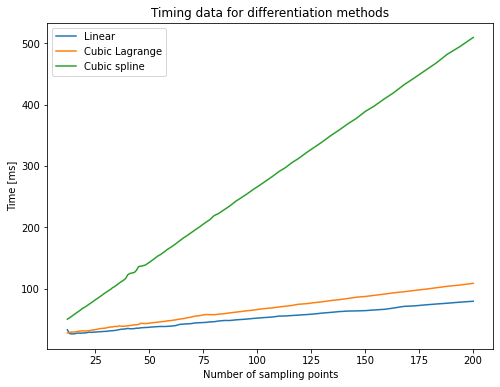

In [105]:
# Time versus number of bins
from datetime import datetime, timedelta

def get_times(deriv, nbins):
    times = []
    for n in nbins:
        xs = np.geomspace(1, 100, n+1)
        ys = gauss(xs)

        trials = []
        for t in range(1000):
            start = datetime.now()
            lin = dif(deriv, xs, ys)
            stop = datetime.now()
            trials.append((stop - start) / timedelta(microseconds=1))
        times.append(np.average(trials))
    return times

nbins = np.unique(np.geomspace(12, 200, 100).astype(int))
plt.figure(figsize=(8,6))
for i, l in zip([lib.linear_diff, lib.cubic_diff, lib.spline_diff],
                ['Linear', 'Cubic Lagrange', 'Cubic spline']):
    times = get_times(i, nbins)
    plt.plot(nbins, times, '-', label=l)
    # slope = linregress(np.log(nbins), np.log(times).astype('float64')).slope
    # plt.plot(np.log(nbins), np.log(times), '-', label=f"{l} (slope: {slope:.2f})")
plt.legend()
plt.title('Timing data for differentiation methods')
plt.xlabel('Number of sampling points')
plt.ylabel('Time [ms]')
# plt.savefig('plots/deriv_time.pdf', bbox_inches='tight')
plt.show()